In [18]:
import medmnist
from medmnist import INFO, Evaluator
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import utils
from torch import optim
from torch import device
from torch import inference_mode
import tqdm
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchmetrics import ConfusionMatrix
import mlxtend
from mlxtend.plotting import plot_confusion_matrix
import numpy as np

In [8]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [10]:
data_flag = 'bloodmnist'
info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

train_data = DataClass(split='train', transform=data_transform, download=True)
val_data = DataClass(split='val', transform=data_transform, download=True)
test_data = DataClass(split='test', transform=data_transform, download=True)

Using downloaded and verified file: C:\Users\ssoko\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\ssoko\.medmnist\bloodmnist.npz
Using downloaded and verified file: C:\Users\ssoko\.medmnist\bloodmnist.npz


In [11]:
img = train_data[0][0]
label = train_data[0][1]

print(f"Image:\n {img}") 
print(f"Label:\n {label}")

print(f"Image shape: {img.shape}")
print(f"Label: {label}")

Image:
 tensor([[[0.9608, 1.0000, 0.9686,  ..., 1.0000, 0.9686, 1.0000],
         [1.0000, 1.0000, 0.9137,  ..., 0.9922, 0.9922, 1.0000],
         [1.0000, 1.0000, 0.8667,  ..., 1.0000, 0.9686, 1.0000],
         ...,
         [0.8275, 0.8745, 0.9216,  ..., 1.0000, 1.0000, 1.0000],
         [0.6863, 0.7098, 0.7882,  ..., 1.0000, 0.9922, 1.0000],
         [0.7020, 0.6627, 0.6706,  ..., 0.9922, 1.0000, 1.0000]],

        [[0.7490, 0.7961, 0.7412,  ..., 0.8667, 0.8039, 0.8353],
         [0.7961, 0.7961, 0.6863,  ..., 0.8196, 0.8275, 0.8980],
         [0.8118, 0.7804, 0.6471,  ..., 0.8275, 0.7961, 0.8980],
         ...,
         [0.6000, 0.6471, 0.7098,  ..., 0.7647, 0.7725, 0.7882],
         [0.4431, 0.4745, 0.5529,  ..., 0.7647, 0.7804, 0.7882],
         [0.4275, 0.4118, 0.4196,  ..., 0.7725, 0.7804, 0.7882]],

        [[0.6157, 0.6627, 0.6157,  ..., 0.5294, 0.4510, 0.4980],
         [0.6471, 0.6471, 0.5608,  ..., 0.5137, 0.4902, 0.5765],
         [0.6314, 0.6078, 0.4824,  ..., 0.5843, 0.

In [100]:
# Number of image channels
n_channels = info['n_channels']
print(f"number of channels: {n_channels}")

# Number of classes
n_classes = len(info['label'])
print(f"number of classes: {n_classes}")

# Get the class names from the dataset
class_names = info['label']
print(f"class names: {class_names}")



train_len = len(train_data)
val_len = len(val_data)
test_len = len(test_data)

# Total dataset length
total_len = train_len + val_len + test_len

# Print results
print(f"Train set: {train_len} samples")
print(f"Validation set: {val_len} samples")
print(f"Test set: {test_len} samples")
print(f"Total dataset: {total_len} samples")

number of channels: 3
number of classes: 8
class names: {'0': 'basophil', '1': 'eosinophil', '2': 'erythroblast', '3': 'immature granulocytes(myelocytes, metamyelocytes and promyelocytes)', '4': 'lymphocyte', '5': 'monocyte', '6': 'neutrophil', '7': 'platelet'}
Train set: 11959 samples
Validation set: 1712 samples
Test set: 3421 samples
Total dataset: 17092 samples


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.7411765..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.79607844..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8901961..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.60784316..1.0].


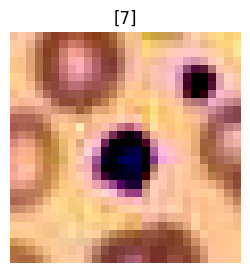

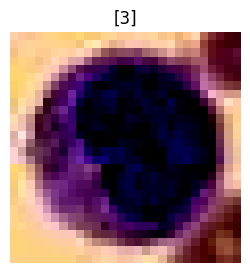

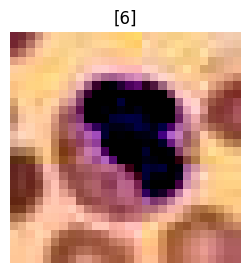

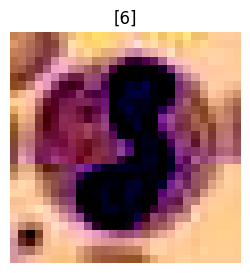

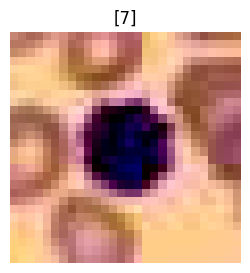

In [12]:
for i in range(5):
    img = train_data[i][0]
    label = train_data[i][1]
    plt.figure(figsize=(3, 3))
    plt.imshow(img.permute(1, 2, 0))
    plt.title(label)
    plt.axis(False);

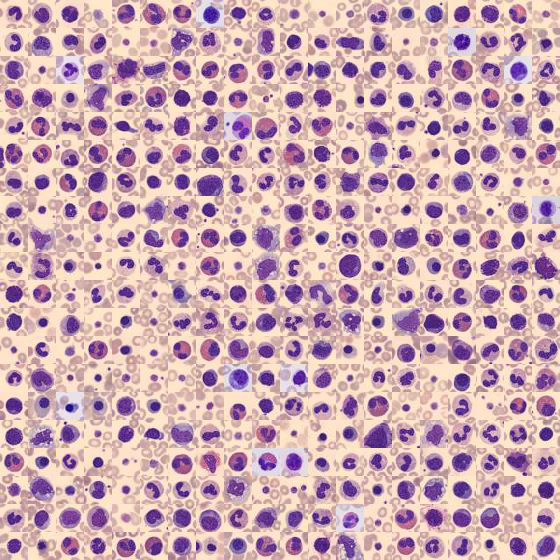

In [14]:
train_data.montage(length=20)

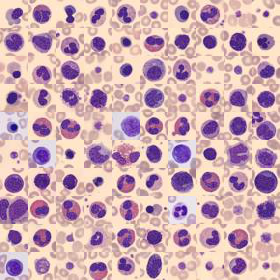

In [127]:
train_data.montage(length=10)

In [124]:
def plot_label_distribution(dataset_name):
    #plt.title(dataset_name)
    fig, axs = plt.subplots(nrows=3, ncols=1)
    train_labels = train_data.labels
    val_labels= val_data.labels
    test_labels=test_data.labels
    
   
    
    axs[0].hist(train_labels, bins=np.max(train_labels) + 1)
    axs[0].set_title('Train data distribution')
    axs[0].set_ylabel('# Images')
    axs[1].hist(val_labels, bins=np.max(val_labels) + 1)
    axs[1].set_ylabel('# Images')
    axs[1].set_title('Validation data distribution')
    axs[2].hist(test_labels, bins=np.max(test_labels) + 1)
    axs[2].set_title('Test data distribution')
    axs[2].set_ylabel('# Images')
    
    fig.tight_layout()
    plt.show()
   
 

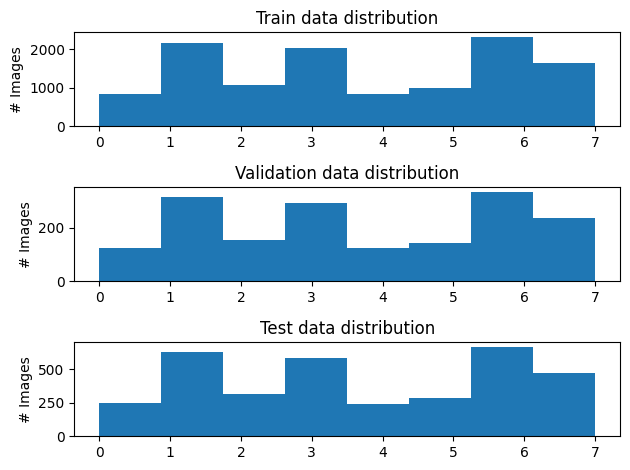

In [125]:
plot_label_distribution('BloodMNIST')